In [1]:
!pip install ultralytics supervision
!pip install git+https://github.com/NVlabs/describe-anything


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
!pip install --upgrade numpy




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dam 1.0.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [1]:
import time
import psutil
from IPython.display import display, Javascript

# Initialize tracking variables
if 'start_time' not in globals():
    start_time = time.time()
    initial_ram = psutil.virtual_memory().used / (1024 ** 3)  # GB
    print("Tracking started for all cells...")

Tracking started for all cells...


In [2]:
import torch
from ultralytics import SAM

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load SAM 2 base model checkpoint (choose "sam2_b.pt", "sam2_l.pt", or "sam2_h.pt")
sam = SAM("sam2_b.pt").to(DEVICE)
print("SAM 2 model loaded on", DEVICE)

# Optional: show model info
sam.info()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 154M/154M [00:01<00:00, 108MB/s]


SAM 2 model loaded on cuda
Model summary: 403 layers, 80,833,666 parameters, 80,833,666 gradients


(403, 80833666, 80833666, 0.0)

In [3]:
#Helper
import numpy as np
import matplotlib.pyplot as plt
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0) #alpha=0.6 makes the mask semi-transparent.
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [5]:
print("SAM 2 model loaded on", DEVICE)

SAM 2 model loaded on cuda


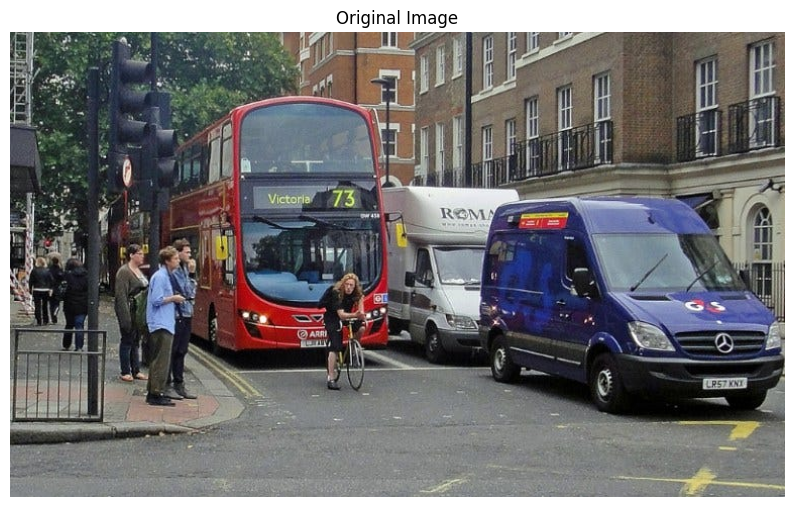

In [7]:
# Cell 5: Load your image
import cv2
image_path = "/content/1_v0Bm-HQxWtpbQ0Yq463uqw.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [8]:
# Segment entire image without prompts
results = sam(image)  # returns list of Results objects
result = results[0]   # single image result

# masks.data is a torch tensor (num_masks, H, W)
masks_tensor = result.masks.data
masks = masks_tensor.cpu().numpy().astype(bool)

print(f"Total masks generated: {len(masks)}")




0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 14343.1ms
Speed: 85.4ms preprocess, 14343.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)
Total masks generated: 19


In [9]:
!pip install ultralytics


In [10]:
from ultralytics import YOLO

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo = YOLO('yolov8m.pt').to(DEVICE)  # You can choose yolov8s.pt, yolov8l.pt, etc.

print("YOLOv8 model loaded with COCO classes.")

100%|██████████| 49.7M/49.7M [00:00<00:00, 267MB/s]


YOLOv8 model loaded with COCO classes.


In [11]:
def detect_objects(image, score_threshold=0.1):
    results = yolo.predict(image, conf=score_threshold, verbose=False)

    detections = []
    for result in results:
        for box in result.boxes:
            xyxy = box.xyxy.cpu().numpy()[0].tolist()
            conf = box.conf.cpu().numpy()[0]
            cls_id = int(box.cls.cpu().numpy()[0])
            label = yolo.model.names[cls_id] if hasattr(yolo.model, 'names') else str(cls_id)

            detections.append({
                'bbox': [int(coord) for coord in xyxy],  # [x1,y1,x2,y2]
                'label': label,
                'score': float(conf)
            })

    return sorted(detections, key=lambda x: x['score'], reverse=True)


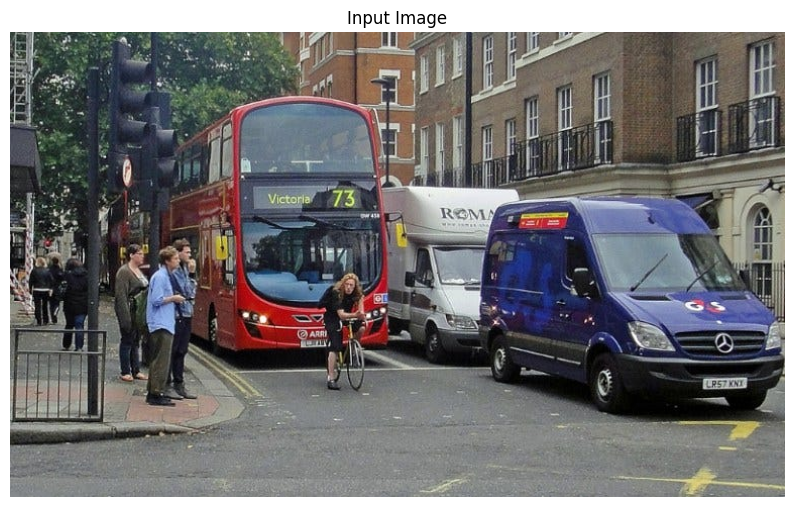

In [12]:
# Cell 13: Load and display input image
image_path = "/content/1_v0Bm-HQxWtpbQ0Yq463uqw.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()


In [13]:
detections = detect_objects(image, score_threshold=0.15)

print(f"Detected {len(detections)} objects:")
for det in detections:
    print(f"- {det['label']} (confidence: {det['score']:.2f}): {det['bbox']}")


Detected 15 objects:
- bus (confidence: 0.95): [152, 63, 376, 320]
- truck (confidence: 0.86): [370, 152, 505, 330]
- person (confidence: 0.84): [304, 238, 355, 355]
- person (confidence: 0.80): [103, 212, 137, 346]
- person (confidence: 0.78): [48, 225, 78, 316]
- person (confidence: 0.77): [133, 212, 178, 372]
- person (confidence: 0.77): [18, 224, 44, 292]
- truck (confidence: 0.76): [463, 162, 767, 379]
- traffic light (confidence: 0.71): [99, 7, 142, 115]
- bicycle (confidence: 0.67): [324, 280, 355, 356]
- person (confidence: 0.46): [158, 226, 185, 365]
- person (confidence: 0.43): [36, 221, 55, 290]
- person (confidence: 0.29): [162, 206, 184, 243]
- person (confidence: 0.21): [122, 246, 140, 335]
- traffic light (confidence: 0.16): [143, 96, 166, 155]


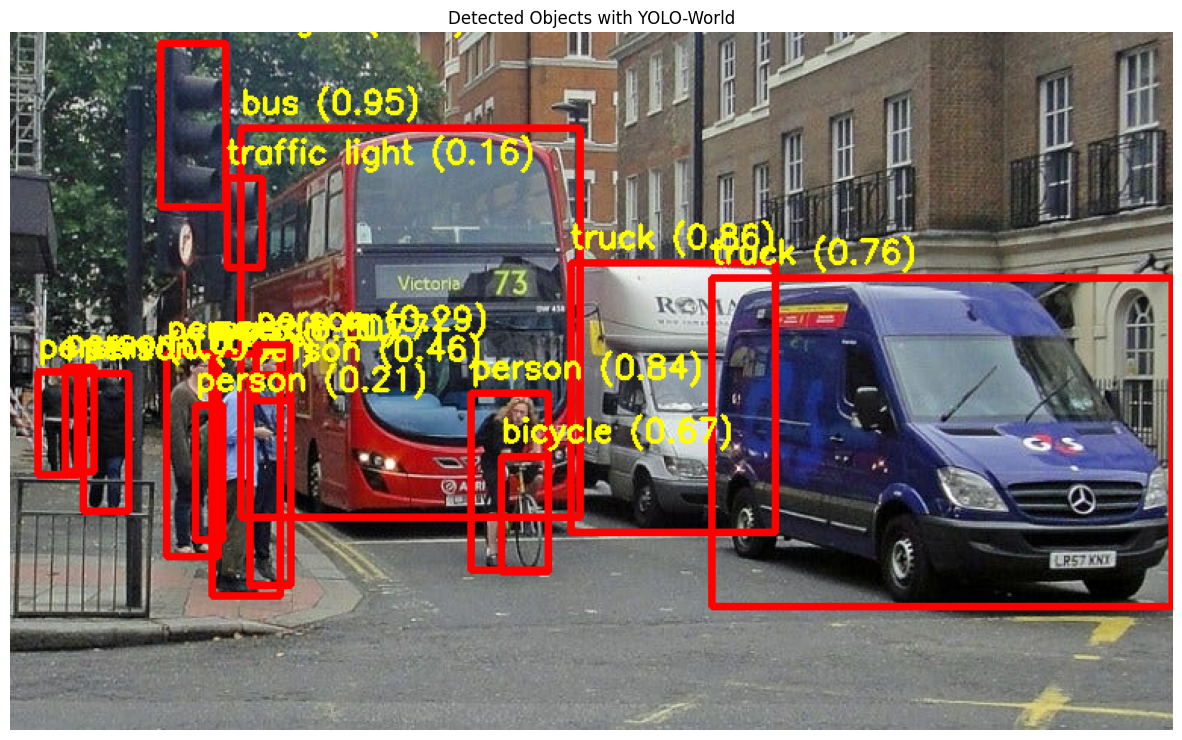

In [14]:
vis_image = image.copy()

for det in detections:
    x1, y1, x2, y2 = det['bbox']
    cv2.rectangle(vis_image, (x1, y1), (x2, y2), (255, 0, 0), 3)
    label = f"{det['label']} ({det['score']:.2f})"
    cv2.putText(vis_image, label, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

plt.figure(figsize=(15, 10))
plt.imshow(vis_image)
plt.axis('off')
plt.title("Detected Objects with YOLO-World")
plt.show()



In [15]:
import json
import cv2

with open("detections.json", "w") as f:
    json.dump(detections, f, indent=2)

cv2.imwrite("detected_objects.jpg", cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR))
print("Results saved to detections.json and detected_objects.jpg")


Results saved to detections.json and detected_objects.jpg


In [18]:
def calculate_iou(mask, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    bbox_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    cv2.rectangle(bbox_mask, (x1, y1), (x2, y2), 255, -1)
    mask_bool = mask > 0
    bbox_bool = bbox_mask > 0
    intersection = np.logical_and(mask_bool, bbox_bool).sum()
    union = np.logical_or(mask_bool, bbox_bool).sum()
    return intersection / max(union, 1e-6)

binary_masks = [m.astype(np.uint8) for m in masks]

object_groups = []
for det in detections:
    group = {
        'label': det['label'],
        'bbox': [int(x) for x in det['bbox']],
        'masks': []
    }
    for mask in binary_masks:
        iou = calculate_iou(mask, group['bbox'])
        if iou > 0.5:
            group['masks'].append(mask)
    object_groups.append(group)


In [19]:
def mask_to_bbox(mask):
    """Convert binary mask to bounding box coordinates [x1,y1,x2,y2]"""
    contours, _ = cv2.findContours(mask.astype(np.uint8),
                 cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x, y, w, h = cv2.boundingRect(contours[0])
    return [x, y, x+w, y+h]

final_objects = []

for group in object_groups:
    if not group['masks']:
        continue

    merged = np.zeros_like(binary_masks[0], dtype=np.uint8)
    for mask in group['masks']:
        merged = cv2.bitwise_or(merged, mask.astype(np.uint8))
    bbox_coords = mask_to_bbox(merged > 0)
    if bbox_coords is None:
        continue

    x1, y1, x2, y2 = bbox_coords
    h, w = image.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    if x2 <= x1 or y2 <= y1:
        continue

    cropped = image[y1:y2, x1:x2]
    masked_crop = cv2.bitwise_and(cropped, cropped, mask=merged[y1:y2, x1:x2])

    final_objects.append({
        'label': group['label'],
        'bbox': [x1, y1, x2, y2],
        'merged_mask': merged[y1:y2, x1:x2],
        'cropped_image': masked_crop
    })

print(f"Successfully processed {len(final_objects)} objects")


Successfully processed 5 objects


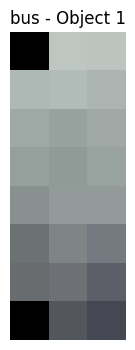

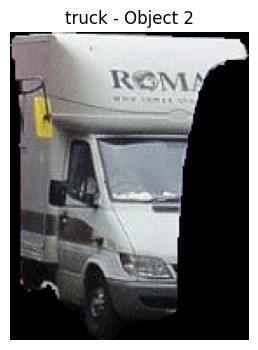

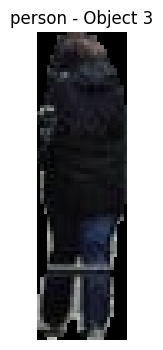

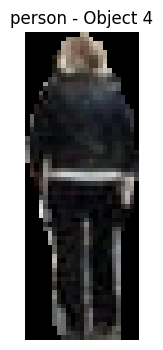

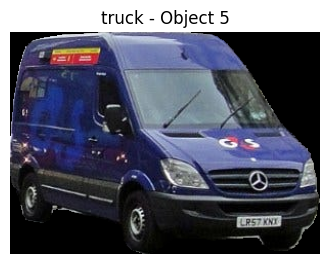

In [20]:
for i, obj in enumerate(final_objects):
    plt.figure(figsize=(4, 4))
    plt.title(f"{obj['label']} - Object {i+1}")
    plt.imshow(obj['cropped_image'])
    plt.axis('off')
    plt.show()


In [21]:
import os
save_dir = "cropped_objects"
os.makedirs(save_dir, exist_ok=True)

for i, obj in enumerate(final_objects):
    cropped_img = obj['cropped_image']
    cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    filename = f"{obj['label']}_object_{i+1}.png"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, cropped_img)
    print(f"Saved {filepath}")


Saved cropped_objects/bus_object_1.png
Saved cropped_objects/truck_object_2.png
Saved cropped_objects/person_object_3.png
Saved cropped_objects/person_object_4.png
Saved cropped_objects/truck_object_5.png


In [22]:
from dam.describe_anything_model import DescribeAnythingModel


In [23]:
from PIL import Image
import torch
model = DescribeAnythingModel(
    model_path="nvidia/DAM-3B",
    conv_mode="v1",
    prompt_mode="full+crop",
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/823M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/989 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.37k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

trainer_state.json:   0%|          | 0.00/120k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/857M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
image = Image.open("/content/1_v0Bm-HQxWtpbQ0Yq463uqw.jpg").convert("RGB")


In [25]:
import numpy as np
import cv2
from PIL import Image

def numpy_to_pil_mask(np_img):
    if len(np_img.shape) == 3 and np_img.shape[2] == 3:
        np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(np_img).convert("L")
    else:
        pil_img = Image.fromarray(np_img).convert("L")
    return pil_img

def embed_mask_in_full_image(mask_crop, bbox, full_shape):
    full_mask = np.zeros(full_shape, dtype=np.uint8)
    x1, y1, x2, y2 = bbox
    resized_mask = cv2.resize(mask_crop, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
    full_mask[y1:y2, x1:x2] = resized_mask
    return full_mask

descriptions = []

if isinstance(image, Image.Image):
    image_np = np.array(image)  # RGB
    image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

image_height, image_width = image.shape[:2]

for i, obj in enumerate(final_objects):
    bbox = obj['bbox']
    mask_crop = obj['merged_mask']  # smaller mask cropped to bbox size or close
    full_mask = embed_mask_in_full_image(mask_crop, bbox, (image_height, image_width))
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    mask_pil = numpy_to_pil_mask(full_mask)

    query = "<image> Describe the object in the highlighted region in detail."

    description = model.get_description(
        image_pil=image_pil,
        mask_pil=mask_pil,
        query=query,
        temperature=0.2,
        top_p=0.9,
        num_beams=1,
        max_new_tokens=512,
    )

    print(f"Description for object {i+1} ({obj['label']}):\n{description}\n")
    descriptions.append(description)


Description for object 1 (bus):
The visible part of the bus is a dark-colored section with a smooth surface.

Description for object 2 (truck):
A white delivery truck with a high roof and a large cargo area. The front cab features a black grille, a pair of rectangular headlights, and a side mirror on the driver's side. The truck's body has a gray lower panel and a black stripe running along the side. The cargo area has a roll-up rear door and is adorned with a logo and text on the side.

Description for object 3 (person):
A person wearing a black coat with a hood, blue jeans, and black shoes.

Description for object 4 (person):
A person with shoulder-length hair wearing a dark jacket over a white shirt, paired with dark pants.

Description for object 5 (truck):
A blue Mercedes-Benz Sprinter van with a high roof and a sliding side door. The van features a prominent logo on the front grille, a windshield with a single wiper, and a side mirror on the driver's side. The license plate reads

In [26]:
# Calculate total metrics
total_time = time.time() - start_time
final_ram = psutil.virtual_memory().used / (1024 ** 3)
ram_used = final_ram - initial_ram

print("\n" + "="*50)
print(f"TOTAL PROCESSING TIME FOR ALL CELLS: {total_time:.2f} seconds")
print(f"TOTAL RAM CONSUMPTION: {ram_used:.2f} GB")
print("="*50)

# Show GPU summary
!nvidia-smi



TOTAL PROCESSING TIME FOR ALL CELLS: 401.43 seconds
TOTAL RAM CONSUMPTION: 3.11 GB
Mon May 19 11:16:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             31W /   70W |   10868MiB /  15360MiB |      0%      Default |
|                                         |             